# Cropping and Resizing Images in 4-class Images Dataset

## Imports

In [1]:
import os
import xml.etree.ElementTree as ET
from skimage import io
from skimage.transform import resize
import glob
from pathlib import Path
import numpy as np


## Get Bounding Boxes

In [2]:
def get_bounding_boxes(annot):
    tree = ET.parse(annot)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox

## Crop and Resize

In [3]:
def process_image(image_file, bounding_boxes, output_folder):
    image = io.imread(image_file)
    image_size=(128, 128)

    cropped_image_list = []
    
    for i, bbox in enumerate(bounding_boxes):
        xmin, ymin, xmax, ymax = bbox
        cropped_image = image[ymin:ymax, xmin:xmax]
        resized_image = resize(cropped_image, image_size)
        
        resized_image_uint8 = (resized_image * 255).astype(np.uint8)
        
        output_path = os.path.join(output_folder, f"cropped_{os.path.basename(image_file)}")
        Path(output_folder).mkdir(parents=True, exist_ok=True)
        io.imsave(output_path, resized_image_uint8)
        cropped_image_list.append(output_path)

    return cropped_image_list
    

## Folders Settings

In [4]:
image_folder = './data/Images/*/*'
annotation_folder = './data/Annotations/*/*'
output_folder = './data/Cropped Images'

image_files = glob.glob(image_folder)
annotation_files = glob.glob(annotation_folder)


## Run

In [5]:
annotations = {os.path.splitext(os.path.basename(f))[0]: f for f in annotation_files}

for image_file in image_files:
    image_code_name = os.path.splitext(os.path.basename(image_file))[0]
    annotation_file = annotations.get(image_code_name)
    
    bbox = get_bounding_boxes(annotation_file)
    breed_folder = os.path.basename(os.path.dirname(image_file))
    breed_output_folder = os.path.join(output_folder, breed_folder)     
    cropped_images = process_image(image_file, bbox, breed_output_folder)       
        

---

# Feature Extraction: Edge histogram AND Similarity Measurements

## Imports

In [51]:
import matplotlib.pyplot as plt
from skimage import color, filters, exposure
from sklearn.metrics import pairwise_distances
import random
from sklearn import metrics

## Load and Grayscale

In [52]:
def load_and_grayscale(image_path):
    image = io.imread(image_path)
    grayscaled_image = color.rgb2gray(image)
    
    return grayscaled_image
    

## Angle Calculator

In [53]:
def angle(dx, dy):
    """Calculate the angles between horizontal and vertical operators."""
    return np.mod(np.arctan2(dy, dx), np.pi)


## Angle of Gradients

In [54]:
def edge_angle(image):
    sobel_h = filters.sobel_h(image)
    sobel_v = filters.sobel_v(image)
    angle_sobel = angle(sobel_h, sobel_v)
    return angle_sobel


## Edge Histograms

In [55]:
def compute_histogram(image_angle):
    hist, bin_centers = exposure.histogram(image_angle, nbins=36)
    return hist, bin_centers
    

## Plotting Image and Histogram

In [56]:
def plotting(image, hist, bin_centers, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title(f'{title} - Grayscaled Image')

    ax[1].bar(bin_centers, hist, width=0.1)
    ax[1].set_title(f'{title} - Edge Histogram')
    ax[1].set_xlabel("Bins")
    ax[1].set_ylabel("Pixel Count")
    plt.show()


## Distances Between Histograms

In [57]:
def compute_distances(hist1, hist2):
    hist1 = hist1.reshape(1, -1)
    hist2 = hist2.reshape(1, -1)
    
    euclidean = metrics.pairwise.euclidean_distances(hist1, hist2)
    manhattan = metrics.pairwise.manhattan_distances(hist1, hist2)
    cosine = metrics.pairwise.cosine_distances(hist1, hist2)
   
    return euclidean, manhattan, cosine


## Breed names

In [58]:
def extract_breed_name(folder_name):
    breed_name = folder_name.split('-')[-1] 
    breed_name = breed_name.replace('_', ' ')
    return breed_name.title()

## Run

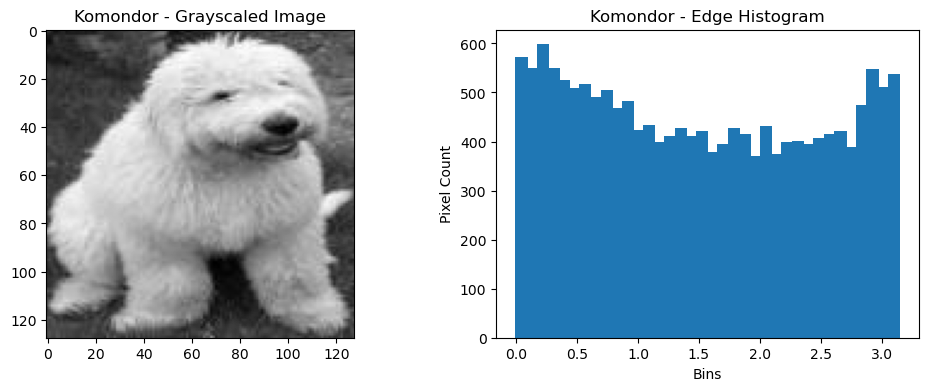

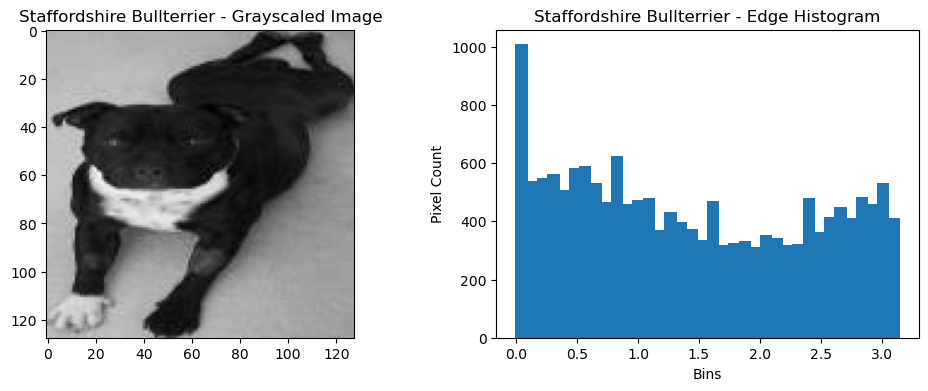

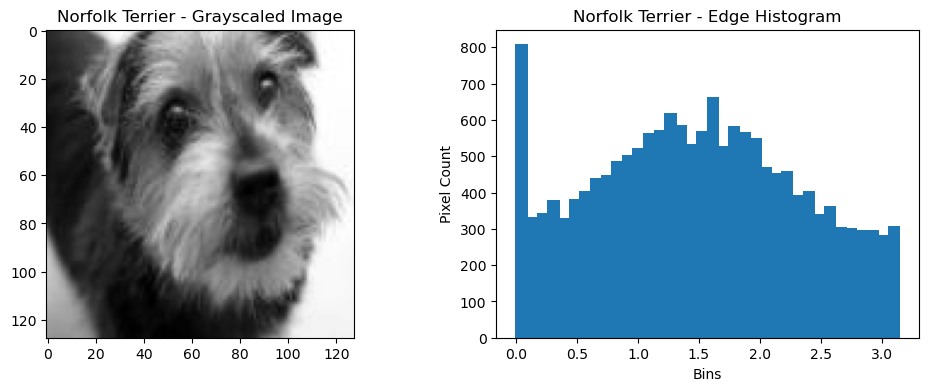

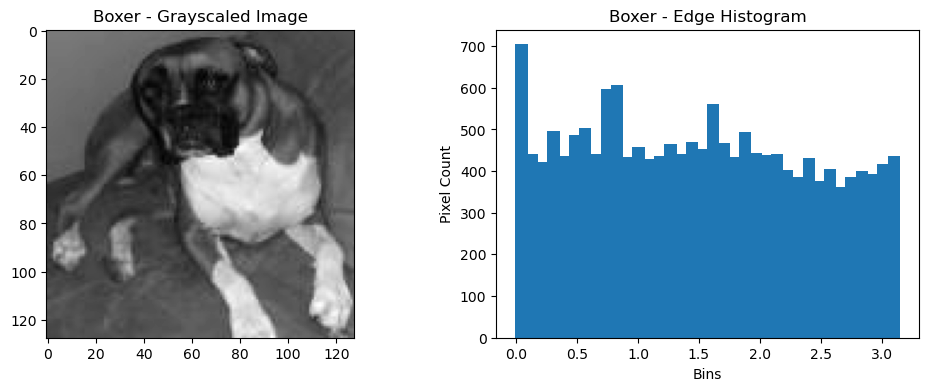

Comparison of 'Komondor' and 'Staffordshire Bullterrier':
Euclidean Distance: [[578.54126906]]
Manhattan Distance: [[2326.]]
Cosine Distance: [[0.02100193]]


In [59]:
main_folder = './data/Cropped Images'

folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

folder1, folder2, folder3, folder4 = [os.path.join(main_folder, folders[i]) for i in range(4)]

image1 = os.path.join(folder1, random.choice(os.listdir(folder1)))
image2 = os.path.join(folder2, random.choice(os.listdir(folder2)))
image3 = os.path.join(folder3, random.choice(os.listdir(folder3)))
image4 = os.path.join(folder4, random.choice(os.listdir(folder4)))

breed_name1 = extract_breed_name(os.path.basename(os.path.dirname(image1)))
breed_name2 = extract_breed_name(os.path.basename(os.path.dirname(image2)))
breed_name3 = extract_breed_name(os.path.basename(os.path.dirname(image3)))
breed_name4 = extract_breed_name(os.path.basename(os.path.dirname(image4)))

grayscaled_image1 = load_and_grayscale(image1)
grayscaled_image2 = load_and_grayscale(image2)
grayscaled_image3 = load_and_grayscale(image3)
grayscaled_image4 = load_and_grayscale(image4)

angle_sobel1 = edge_angle(grayscaled_image1)
angle_sobel2 = edge_angle(grayscaled_image2)
angle_sobel3 = edge_angle(grayscaled_image3)
angle_sobel4 = edge_angle(grayscaled_image4)

hist1, bin_centers1 = compute_histogram(angle_sobel1)
hist2, bin_centers2 = compute_histogram(angle_sobel2)
hist3, bin_centers3 = compute_histogram(angle_sobel3)
hist4, bin_centers4 = compute_histogram(angle_sobel4)

plotting(grayscaled_image1, hist1, bin_centers1, breed_name1)
plotting(grayscaled_image2, hist2, bin_centers2, breed_name2)
plotting(grayscaled_image3, hist3, bin_centers3, breed_name3)
plotting(grayscaled_image4, hist4, bin_centers4, breed_name4)

euclidean, manhattan, cosine = compute_distances(hist1, hist2)

print(f"Comparison of '{breed_name1}' and '{breed_name2}':")
print(f"Euclidean Distance: {euclidean}")
print(f"Manhattan Distance: {manhattan}")
print(f"Cosine Distance: {cosine}")


---

# Histogram of Oriented Gradient (HOG) feature descriptor

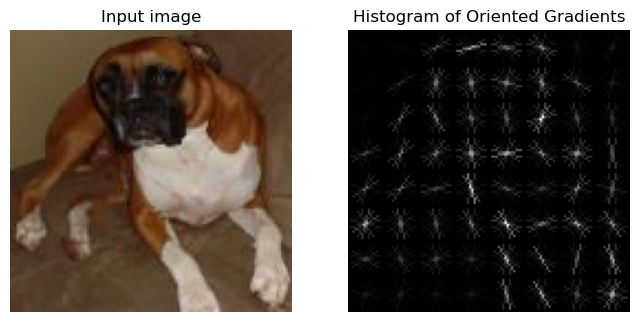

In [60]:
from skimage.feature import hog
from skimage import data

img = io.imread(image4)

fd, hog_image = hog(
    img,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


---

# Dimensionality reduction (using Principal Component Analysis, PCA)

## Imports

In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## All Images to Histograms

In [62]:
def all_to_histograms(image_files, histograms_folder):
    histograms_list = []
    labels = []
    
    for i, image_path in enumerate(image_files):

        class_label_full = os.path.basename(os.path.dirname(image_path))
        class_label = class_label_full.split('-')[1]
        class_label = class_label.replace('_', ' ')
        labels.append(class_label.title())
        
        grayscaled_image = load_and_grayscale(image_path)
        angle_sobel = edge_angle(grayscaled_image)
        hist, bin_centers = compute_histogram(angle_sobel)

        histograms_list.append(hist)

    return histograms_list, labels
    

## Principal Component Analysis (PCA) 

In [63]:
images_folder = './data/Cropped Images/*/*'
histograms_folder = './data/Edge Histograms'
image_files = glob.glob(images_folder)

all_histograms, labels = all_to_histograms(image_files, histograms_folder)
histograms_array = np.array(all_histograms)

scaler = StandardScaler()
histograms_normalized = scaler.fit_transform(histograms_array)

unique_labels = np.unique(labels)
label_mapping = {label: i for i, label in enumerate(unique_labels)}
encoded_labels = np.array([label_mapping[label] for label in labels])

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(histograms_normalized)


## Plotting 2D Points

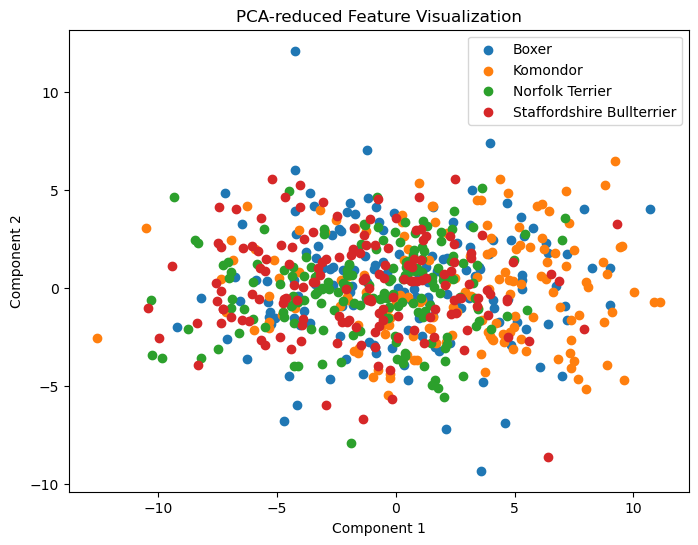

In [64]:
plt.figure(figsize=(8, 6))

for class_label, label_num in label_mapping.items():
    plt.scatter(reduced_data[encoded_labels == label_num, 0], 
                reduced_data[encoded_labels == label_num, 1], 
                label=f'{class_label}')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('PCA-reduced Feature Visualization')
plt.show()

### **Zero** classes are visually separable.